# Pixel centroid changes and mnemonics | PID 2079 Example

In [19]:
import sys
sys.path.append('/Users/ddeal/JWST-FGS-Spelunker/JWST-FGS-Spelunker-main/')
import Spelunker

spk = Spelunker.load('/Users/ddeal/JWST-Treasure-Chest/', pid=2079, obs_num=4, visit=1)

2023-07-18 22:17:07,210 - stpipe - INFO - Found cached file ./mastDownload/JWST/jw02079004001_02101_00001_nis/jw02079004001_gs-fg_2023031214828-seg001_cal.fits with expected size 51960960.


INFO: Found cached file ./mastDownload/JWST/jw02079004001_02101_00001_nis/jw02079004001_gs-fg_2023031214828-seg001_cal.fits with expected size 51960960. [astroquery.query]


2023-07-18 22:17:07,650 - stpipe - INFO - Found cached file ./mastDownload/JWST/jw02079004001_02101_00001_nis/jw02079004001_gs-fg_2023031214828-seg002_cal.fits with expected size 43096320.


INFO: Found cached file ./mastDownload/JWST/jw02079004001_02101_00001_nis/jw02079004001_gs-fg_2023031214828-seg002_cal.fits with expected size 43096320. [astroquery.query]


2023-07-18 22:17:08,088 - stpipe - INFO - Found cached file ./mastDownload/JWST/jw02079004001_02101_00001_nis/jw02079004001_gs-fg_2023031214829-seg001_cal.fits with expected size 64540800.


INFO: Found cached file ./mastDownload/JWST/jw02079004001_02101_00001_nis/jw02079004001_gs-fg_2023031214829-seg001_cal.fits with expected size 64540800. [astroquery.query]


2023-07-18 22:17:08,302 - stpipe - INFO - Found cached file ./mastDownload/JWST/jw02079004001_02101_00001_nis/jw02079004001_gs-fg_2023031214829-seg002_cal.fits with expected size 53496000.


INFO: Found cached file ./mastDownload/JWST/jw02079004001_02101_00001_nis/jw02079004001_gs-fg_2023031214829-seg002_cal.fits with expected size 53496000. [astroquery.query]


2023-07-18 22:17:08,549 - stpipe - INFO - Found cached file ./mastDownload/JWST/jw02079004001_02101_00001_nis/jw02079004001_gs-fg_2023031231651-seg003_cal.fits with expected size 51960960.
2023-07-18 22:17:08,639 - stpipe - INFO - Found cached file ./mastDownload/JWST/jw02079004001_02101_00001_nis/jw02079004001_gs-fg_2023031231651-seg004_cal.fits with expected size 31645440.
2023-07-18 22:17:08,742 - stpipe - INFO - Found cached file ./mastDownload/JWST/jw02079004001_02101_00001_nis/jw02079004001_gs-fg_2023031231652-seg003_cal.fits with expected size 64540800.


INFO: Found cached file ./mastDownload/JWST/jw02079004001_02101_00001_nis/jw02079004001_gs-fg_2023031231651-seg003_cal.fits with expected size 51960960. [astroquery.query]
INFO: Found cached file ./mastDownload/JWST/jw02079004001_02101_00001_nis/jw02079004001_gs-fg_2023031231651-seg004_cal.fits with expected size 31645440. [astroquery.query]
INFO: Found cached file ./mastDownload/JWST/jw02079004001_02101_00001_nis/jw02079004001_gs-fg_2023031231652-seg003_cal.fits with expected size 64540800. [astroquery.query]


2023-07-18 22:17:08,839 - stpipe - INFO - Found cached file ./mastDownload/JWST/jw02079004001_02101_00001_nis/jw02079004001_gs-fg_2023031231652-seg004_cal.fits with expected size 39245760.
2023-07-18 22:17:08,934 - stpipe - INFO - Found cached file ./mastDownload/JWST/jw02079004001_02101_00001_nis/jw02079004001_gs-fg_2023032005233-seg005_cal.fits with expected size 51960960.
2023-07-18 22:17:09,018 - stpipe - INFO - Found cached file ./mastDownload/JWST/jw02079004001_02101_00001_nis/jw02079004001_gs-fg_2023032005233-seg006_cal.fits with expected size 38445120.


INFO: Found cached file ./mastDownload/JWST/jw02079004001_02101_00001_nis/jw02079004001_gs-fg_2023031231652-seg004_cal.fits with expected size 39245760. [astroquery.query]
INFO: Found cached file ./mastDownload/JWST/jw02079004001_02101_00001_nis/jw02079004001_gs-fg_2023032005233-seg005_cal.fits with expected size 51960960. [astroquery.query]
INFO: Found cached file ./mastDownload/JWST/jw02079004001_02101_00001_nis/jw02079004001_gs-fg_2023032005233-seg006_cal.fits with expected size 38445120. [astroquery.query]


2023-07-18 22:17:09,100 - stpipe - INFO - Found cached file ./mastDownload/JWST/jw02079004001_02101_00001_nis/jw02079004001_gs-fg_2023032005234-seg005_cal.fits with expected size 64540800.
2023-07-18 22:17:09,185 - stpipe - INFO - Found cached file ./mastDownload/JWST/jw02079004001_02101_00001_nis/jw02079004001_gs-fg_2023032005234-seg006_cal.fits with expected size 47736000.
2023-07-18 22:17:09,260 - stpipe - INFO - Found cached file ./mastDownload/JWST/jw02079004001_02101_00001_nis/jw02079004001_gs-fg_2023032005730_cal.fits with expected size 5129280.


INFO: Found cached file ./mastDownload/JWST/jw02079004001_02101_00001_nis/jw02079004001_gs-fg_2023032005234-seg005_cal.fits with expected size 64540800. [astroquery.query]
INFO: Found cached file ./mastDownload/JWST/jw02079004001_02101_00001_nis/jw02079004001_gs-fg_2023032005234-seg006_cal.fits with expected size 47736000. [astroquery.query]
INFO: Found cached file ./mastDownload/JWST/jw02079004001_02101_00001_nis/jw02079004001_gs-fg_2023032005730_cal.fits with expected size 5129280. [astroquery.query]


2023-07-18 22:17:09,350 - stpipe - INFO - Found cached file ./mastDownload/JWST/jw02079004001_02101_00001_nis/jw02079004001_gs-fg_2023032010230_cal.fits with expected size 5137920.
2023-07-18 22:17:09,434 - stpipe - INFO - Found cached file ./mastDownload/JWST/jw02079004001_02101_00001_nis/jw02079004001_gs-fg_2023032023826-seg007_cal.fits with expected size 51960960.
2023-07-18 22:17:09,519 - stpipe - INFO - Found cached file ./mastDownload/JWST/jw02079004001_02101_00001_nis/jw02079004001_gs-fg_2023032023826-seg008_cal.fits with expected size 38488320.


INFO: Found cached file ./mastDownload/JWST/jw02079004001_02101_00001_nis/jw02079004001_gs-fg_2023032010230_cal.fits with expected size 5137920. [astroquery.query]
INFO: Found cached file ./mastDownload/JWST/jw02079004001_02101_00001_nis/jw02079004001_gs-fg_2023032023826-seg007_cal.fits with expected size 51960960. [astroquery.query]
INFO: Found cached file ./mastDownload/JWST/jw02079004001_02101_00001_nis/jw02079004001_gs-fg_2023032023826-seg008_cal.fits with expected size 38488320. [astroquery.query]


2023-07-18 22:17:09,596 - stpipe - INFO - Found cached file ./mastDownload/JWST/jw02079004001_02101_00001_nis/jw02079004001_gs-fg_2023032023827-seg007_cal.fits with expected size 64540800.
2023-07-18 22:17:09,685 - stpipe - INFO - Found cached file ./mastDownload/JWST/jw02079004001_02101_00001_nis/jw02079004001_gs-fg_2023032023827-seg008_cal.fits with expected size 48216960.
2023-07-18 22:17:09,784 - stpipe - INFO - Found cached file ./mastDownload/JWST/jw02079004001_02101_00001_nis/jw02079004001_gs-fg_2023032040648-seg009_cal.fits with expected size 51960960.


INFO: Found cached file ./mastDownload/JWST/jw02079004001_02101_00001_nis/jw02079004001_gs-fg_2023032023827-seg007_cal.fits with expected size 64540800. [astroquery.query]
INFO: Found cached file ./mastDownload/JWST/jw02079004001_02101_00001_nis/jw02079004001_gs-fg_2023032023827-seg008_cal.fits with expected size 48216960. [astroquery.query]
INFO: Found cached file ./mastDownload/JWST/jw02079004001_02101_00001_nis/jw02079004001_gs-fg_2023032040648-seg009_cal.fits with expected size 51960960. [astroquery.query]


2023-07-18 22:17:09,873 - stpipe - INFO - Found cached file ./mastDownload/JWST/jw02079004001_02101_00001_nis/jw02079004001_gs-fg_2023032040648-seg010_cal.fits with expected size 31642560.
2023-07-18 22:17:09,964 - stpipe - INFO - Found cached file ./mastDownload/JWST/jw02079004001_02101_00001_nis/jw02079004001_gs-fg_2023032040649-seg009_cal.fits with expected size 64540800.


INFO: Found cached file ./mastDownload/JWST/jw02079004001_02101_00001_nis/jw02079004001_gs-fg_2023032040648-seg010_cal.fits with expected size 31642560. [astroquery.query]
INFO: Found cached file ./mastDownload/JWST/jw02079004001_02101_00001_nis/jw02079004001_gs-fg_2023032040649-seg009_cal.fits with expected size 64540800. [astroquery.query]


2023-07-18 22:17:10,074 - stpipe - INFO - Found cached file ./mastDownload/JWST/jw02079004001_02101_00001_nis/jw02079004001_gs-fg_2023032040649-seg010_cal.fits with expected size 39240000.
2023-07-18 22:17:10,169 - stpipe - INFO - Found cached file ./mastDownload/JWST/jw02079004001_02101_00001_nis/jw02079004001_gs-fg_2023032054253-seg011_cal.fits with expected size 51960960.
2023-07-18 22:17:10,265 - stpipe - INFO - Found cached file ./mastDownload/JWST/jw02079004001_02101_00001_nis/jw02079004001_gs-fg_2023032054253-seg012_cal.fits with expected size 38926080.


INFO: Found cached file ./mastDownload/JWST/jw02079004001_02101_00001_nis/jw02079004001_gs-fg_2023032040649-seg010_cal.fits with expected size 39240000. [astroquery.query]
INFO: Found cached file ./mastDownload/JWST/jw02079004001_02101_00001_nis/jw02079004001_gs-fg_2023032054253-seg011_cal.fits with expected size 51960960. [astroquery.query]
INFO: Found cached file ./mastDownload/JWST/jw02079004001_02101_00001_nis/jw02079004001_gs-fg_2023032054253-seg012_cal.fits with expected size 38926080. [astroquery.query]


2023-07-18 22:17:10,379 - stpipe - INFO - Found cached file ./mastDownload/JWST/jw02079004001_02101_00001_nis/jw02079004001_gs-fg_2023032054254-seg011_cal.fits with expected size 64540800.
2023-07-18 22:17:10,475 - stpipe - INFO - Found cached file ./mastDownload/JWST/jw02079004001_02101_00001_nis/jw02079004001_gs-fg_2023032054254-seg012_cal.fits with expected size 48303360.
2023-07-18 22:17:10,554 - stpipe - INFO - Found cached file ./mastDownload/JWST/jw02079004001_02101_00001_nis/jw02079004001_gs-fg_2023032054750_cal.fits with expected size 5129280.


INFO: Found cached file ./mastDownload/JWST/jw02079004001_02101_00001_nis/jw02079004001_gs-fg_2023032054254-seg011_cal.fits with expected size 64540800. [astroquery.query]
INFO: Found cached file ./mastDownload/JWST/jw02079004001_02101_00001_nis/jw02079004001_gs-fg_2023032054254-seg012_cal.fits with expected size 48303360. [astroquery.query]
INFO: Found cached file ./mastDownload/JWST/jw02079004001_02101_00001_nis/jw02079004001_gs-fg_2023032054750_cal.fits with expected size 5129280. [astroquery.query]


2023-07-18 22:17:10,646 - stpipe - INFO - Found cached file ./mastDownload/JWST/jw02079004001_02101_00001_nis/jw02079004001_gs-fg_2023032055311_cal.fits with expected size 5693760.
2023-07-18 22:17:10,742 - stpipe - INFO - Found cached file ./mastDownload/JWST/jw02079004001_02101_00001_nis/jw02079004001_gs-fg_2023032073157-seg013_cal.fits with expected size 51960960.
2023-07-18 22:17:10,830 - stpipe - INFO - Found cached file ./mastDownload/JWST/jw02079004001_02101_00001_nis/jw02079004001_gs-fg_2023032073157-seg014_cal.fits with expected size 41492160.


INFO: Found cached file ./mastDownload/JWST/jw02079004001_02101_00001_nis/jw02079004001_gs-fg_2023032055311_cal.fits with expected size 5693760. [astroquery.query]
INFO: Found cached file ./mastDownload/JWST/jw02079004001_02101_00001_nis/jw02079004001_gs-fg_2023032073157-seg013_cal.fits with expected size 51960960. [astroquery.query]
INFO: Found cached file ./mastDownload/JWST/jw02079004001_02101_00001_nis/jw02079004001_gs-fg_2023032073157-seg014_cal.fits with expected size 41492160. [astroquery.query]


2023-07-18 22:17:10,906 - stpipe - INFO - Found cached file ./mastDownload/JWST/jw02079004001_02101_00001_nis/jw02079004001_gs-fg_2023032073158-seg013_cal.fits with expected size 64540800.
2023-07-18 22:17:10,986 - stpipe - INFO - Found cached file ./mastDownload/JWST/jw02079004001_02101_00001_nis/jw02079004001_gs-fg_2023032073158-seg014_cal.fits with expected size 51471360.
2023-07-18 22:17:11,079 - stpipe - INFO - Found cached file ./mastDownload/JWST/jw02079004001_02101_00001_nis/jw02079004001_gs-fg_2023032090020-seg015_cal.fits with expected size 51960960.


INFO: Found cached file ./mastDownload/JWST/jw02079004001_02101_00001_nis/jw02079004001_gs-fg_2023032073158-seg013_cal.fits with expected size 64540800. [astroquery.query]
INFO: Found cached file ./mastDownload/JWST/jw02079004001_02101_00001_nis/jw02079004001_gs-fg_2023032073158-seg014_cal.fits with expected size 51471360. [astroquery.query]
INFO: Found cached file ./mastDownload/JWST/jw02079004001_02101_00001_nis/jw02079004001_gs-fg_2023032090020-seg015_cal.fits with expected size 51960960. [astroquery.query]


2023-07-18 22:17:11,181 - stpipe - INFO - Found cached file ./mastDownload/JWST/jw02079004001_02101_00001_nis/jw02079004001_gs-fg_2023032090020-seg016_cal.fits with expected size 31642560.
2023-07-18 22:17:11,270 - stpipe - INFO - Found cached file ./mastDownload/JWST/jw02079004001_02101_00001_nis/jw02079004001_gs-fg_2023032090021-seg015_cal.fits with expected size 64540800.
2023-07-18 22:17:11,350 - stpipe - INFO - Found cached file ./mastDownload/JWST/jw02079004001_02101_00001_nis/jw02079004001_gs-fg_2023032090021-seg016_cal.fits with expected size 39240000.


INFO: Found cached file ./mastDownload/JWST/jw02079004001_02101_00001_nis/jw02079004001_gs-fg_2023032090020-seg016_cal.fits with expected size 31642560. [astroquery.query]
INFO: Found cached file ./mastDownload/JWST/jw02079004001_02101_00001_nis/jw02079004001_gs-fg_2023032090021-seg015_cal.fits with expected size 64540800. [astroquery.query]
INFO: Found cached file ./mastDownload/JWST/jw02079004001_02101_00001_nis/jw02079004001_gs-fg_2023032090021-seg016_cal.fits with expected size 39240000. [astroquery.query]


2023-07-18 22:17:11,450 - stpipe - INFO - Found cached file ./mastDownload/JWST/jw02079004001_02101_00001_nis/jw02079004001_gs-fg_2023032103608-seg017_cal.fits with expected size 51960960.
2023-07-18 22:17:11,537 - stpipe - INFO - Found cached file ./mastDownload/JWST/jw02079004001_02101_00001_nis/jw02079004001_gs-fg_2023032103608-seg018_cal.fits with expected size 38859840.
2023-07-18 22:17:11,630 - stpipe - INFO - Found cached file ./mastDownload/JWST/jw02079004001_02101_00001_nis/jw02079004001_gs-fg_2023032103609-seg017_cal.fits with expected size 64540800.


INFO: Found cached file ./mastDownload/JWST/jw02079004001_02101_00001_nis/jw02079004001_gs-fg_2023032103608-seg017_cal.fits with expected size 51960960. [astroquery.query]
INFO: Found cached file ./mastDownload/JWST/jw02079004001_02101_00001_nis/jw02079004001_gs-fg_2023032103608-seg018_cal.fits with expected size 38859840. [astroquery.query]
INFO: Found cached file ./mastDownload/JWST/jw02079004001_02101_00001_nis/jw02079004001_gs-fg_2023032103609-seg017_cal.fits with expected size 64540800. [astroquery.query]


2023-07-18 22:17:11,729 - stpipe - INFO - Found cached file ./mastDownload/JWST/jw02079004001_02101_00001_nis/jw02079004001_gs-fg_2023032103609-seg018_cal.fits with expected size 48170880.
2023-07-18 22:17:11,814 - stpipe - INFO - Found cached file ./mastDownload/JWST/jw02079004001_02101_00001_nis/jw02079004001_gs-fg_2023032104106_cal.fits with expected size 5137920.


INFO: Found cached file ./mastDownload/JWST/jw02079004001_02101_00001_nis/jw02079004001_gs-fg_2023032103609-seg018_cal.fits with expected size 48170880. [astroquery.query]
INFO: Found cached file ./mastDownload/JWST/jw02079004001_02101_00001_nis/jw02079004001_gs-fg_2023032104106_cal.fits with expected size 5137920. [astroquery.query]


2023-07-18 22:17:11,983 - stpipe - INFO - Found cached file ./mastDownload/JWST/jw02079004001_02101_00001_nis/jw02079004001_gs-fg_2023032104608_cal.fits with expected size 5146560.
2023-07-18 22:17:12,070 - stpipe - INFO - Found cached file ./mastDownload/JWST/jw02079004001_02101_00001_nis/jw02079004001_gs-fg_2023032122200-seg019_cal.fits with expected size 51960960.
2023-07-18 22:17:12,144 - stpipe - INFO - Found cached file ./mastDownload/JWST/jw02079004001_02101_00001_nis/jw02079004001_gs-fg_2023032122200-seg020_cal.fits with expected size 38862720.


INFO: Found cached file ./mastDownload/JWST/jw02079004001_02101_00001_nis/jw02079004001_gs-fg_2023032104608_cal.fits with expected size 5146560. [astroquery.query]
INFO: Found cached file ./mastDownload/JWST/jw02079004001_02101_00001_nis/jw02079004001_gs-fg_2023032122200-seg019_cal.fits with expected size 51960960. [astroquery.query]
INFO: Found cached file ./mastDownload/JWST/jw02079004001_02101_00001_nis/jw02079004001_gs-fg_2023032122200-seg020_cal.fits with expected size 38862720. [astroquery.query]


2023-07-18 22:17:12,242 - stpipe - INFO - Found cached file ./mastDownload/JWST/jw02079004001_02101_00001_nis/jw02079004001_gs-fg_2023032122201-seg019_cal.fits with expected size 64540800.
2023-07-18 22:17:12,348 - stpipe - INFO - Found cached file ./mastDownload/JWST/jw02079004001_02101_00001_nis/jw02079004001_gs-fg_2023032122201-seg020_cal.fits with expected size 48179520.


INFO: Found cached file ./mastDownload/JWST/jw02079004001_02101_00001_nis/jw02079004001_gs-fg_2023032122201-seg019_cal.fits with expected size 64540800. [astroquery.query]
INFO: Found cached file ./mastDownload/JWST/jw02079004001_02101_00001_nis/jw02079004001_gs-fg_2023032122201-seg020_cal.fits with expected size 48179520. [astroquery.query]


2023-07-18 22:17:12,463 - stpipe - INFO - Found cached file ./mastDownload/JWST/jw02079004001_02101_00001_nis/jw02079004001_gs-fg_2023032135024-seg021_cal.fits with expected size 51960960.
2023-07-18 22:17:12,558 - stpipe - INFO - Found cached file ./mastDownload/JWST/jw02079004001_02101_00001_nis/jw02079004001_gs-fg_2023032135024-seg022_cal.fits with expected size 31651200.


INFO: Found cached file ./mastDownload/JWST/jw02079004001_02101_00001_nis/jw02079004001_gs-fg_2023032135024-seg021_cal.fits with expected size 51960960. [astroquery.query]
INFO: Found cached file ./mastDownload/JWST/jw02079004001_02101_00001_nis/jw02079004001_gs-fg_2023032135024-seg022_cal.fits with expected size 31651200. [astroquery.query]


2023-07-18 22:17:12,675 - stpipe - INFO - Found cached file ./mastDownload/JWST/jw02079004001_02101_00001_nis/jw02079004001_gs-fg_2023032135025-seg021_cal.fits with expected size 64540800.
2023-07-18 22:17:12,791 - stpipe - INFO - Found cached file ./mastDownload/JWST/jw02079004001_02101_00001_nis/jw02079004001_gs-fg_2023032135025-seg022_cal.fits with expected size 39257280.


INFO: Found cached file ./mastDownload/JWST/jw02079004001_02101_00001_nis/jw02079004001_gs-fg_2023032135025-seg021_cal.fits with expected size 64540800. [astroquery.query]
INFO: Found cached file ./mastDownload/JWST/jw02079004001_02101_00001_nis/jw02079004001_gs-fg_2023032135025-seg022_cal.fits with expected size 39257280. [astroquery.query]


2023-07-18 22:17:12,899 - stpipe - INFO - Found cached file ./mastDownload/JWST/jw02079004001_02101_00001_nis/jw02079004001_gs-fg_2023032152632-seg023_cal.fits with expected size 51960960.
2023-07-18 22:17:12,994 - stpipe - INFO - Found cached file ./mastDownload/JWST/jw02079004001_02101_00001_nis/jw02079004001_gs-fg_2023032152632-seg024_cal.fits with expected size 38934720.


INFO: Found cached file ./mastDownload/JWST/jw02079004001_02101_00001_nis/jw02079004001_gs-fg_2023032152632-seg023_cal.fits with expected size 51960960. [astroquery.query]
INFO: Found cached file ./mastDownload/JWST/jw02079004001_02101_00001_nis/jw02079004001_gs-fg_2023032152632-seg024_cal.fits with expected size 38934720. [astroquery.query]


2023-07-18 22:17:13,101 - stpipe - INFO - Found cached file ./mastDownload/JWST/jw02079004001_02101_00001_nis/jw02079004001_gs-fg_2023032152633-seg023_cal.fits with expected size 64540800.
2023-07-18 22:17:13,207 - stpipe - INFO - Found cached file ./mastDownload/JWST/jw02079004001_02101_00001_nis/jw02079004001_gs-fg_2023032152633-seg024_cal.fits with expected size 48320640.


INFO: Found cached file ./mastDownload/JWST/jw02079004001_02101_00001_nis/jw02079004001_gs-fg_2023032152633-seg023_cal.fits with expected size 64540800. [astroquery.query]
INFO: Found cached file ./mastDownload/JWST/jw02079004001_02101_00001_nis/jw02079004001_gs-fg_2023032152633-seg024_cal.fits with expected size 48320640. [astroquery.query]


2023-07-18 22:17:13,315 - stpipe - INFO - Found cached file ./mastDownload/JWST/jw02079004001_02101_00001_nis/jw02079004001_gs-fg_2023032153129_cal.fits with expected size 5129280.
2023-07-18 22:17:13,433 - stpipe - INFO - Found cached file ./mastDownload/JWST/jw02079004001_02101_00001_nis/jw02079004001_gs-fg_2023032153639_cal.fits with expected size 5610240.


INFO: Found cached file ./mastDownload/JWST/jw02079004001_02101_00001_nis/jw02079004001_gs-fg_2023032153129_cal.fits with expected size 5129280. [astroquery.query]
INFO: Found cached file ./mastDownload/JWST/jw02079004001_02101_00001_nis/jw02079004001_gs-fg_2023032153639_cal.fits with expected size 5610240. [astroquery.query]


In [20]:
spk.mast_api_token = '8eedd0a371a44e598a9c4489e3148811'

Lets look at how many guidestars this program uses.

In [21]:
spk.object_properties

,guidestar_catalog_id,gaiadr1ID,gaiadr1ID,int_start,int_stop,ra,dec,Jmag,Hmag
0,S33T007497,5057488505467609856,5057488509763935872,59975.839346,59975.877272,53.227801,-27.900539,13.761134,13.248195


There is only one guidestar used within this program. Lets look at the flux timeseries for the guidestar in the program.

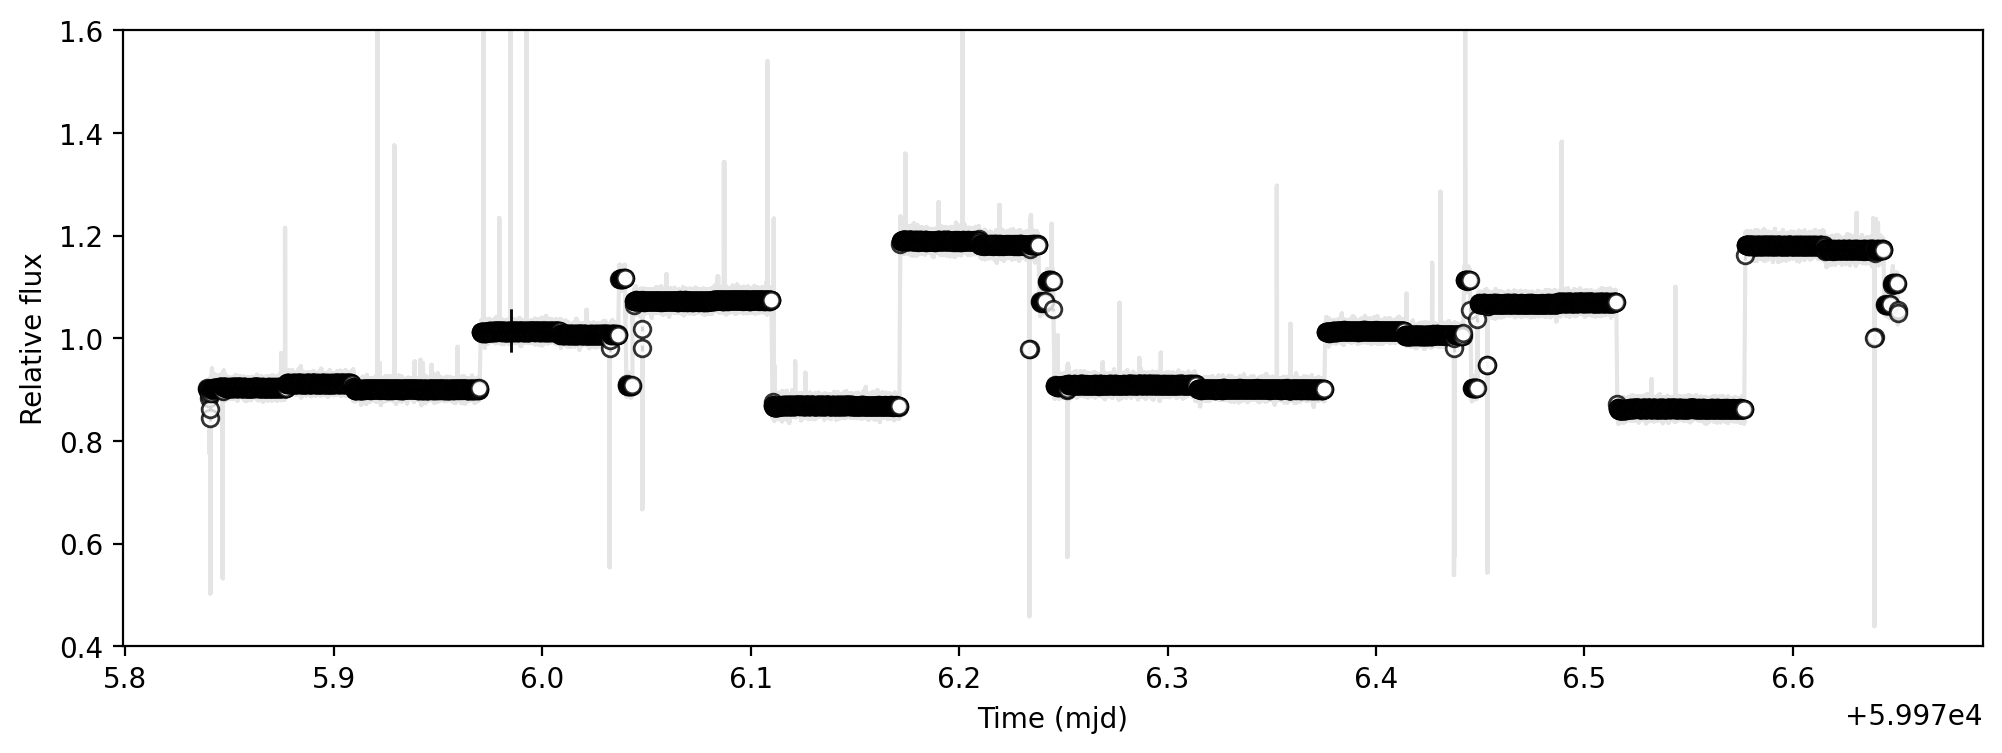

In [22]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12,4), dpi=200)
ax = spk.timeseries_binned_plot(spk.fg_time, spk.fg_flux)

We can see that there are chucks of data points that largely changes in flux for each chunk. Lets see how the obserbed properties of the target changes overtime. We fitted gaussians to each frame using `spk.gauss2d_fit` and saved the outpput as an astropy table `dat` file, so we can load the table here.

In [23]:
from astropy.io import ascii
gaussfit_table = ascii.read('/Users/ddeal/Spelunker-older/JWST-Treasure-Chest-2023/pid2079_observation04_visit1.dat')

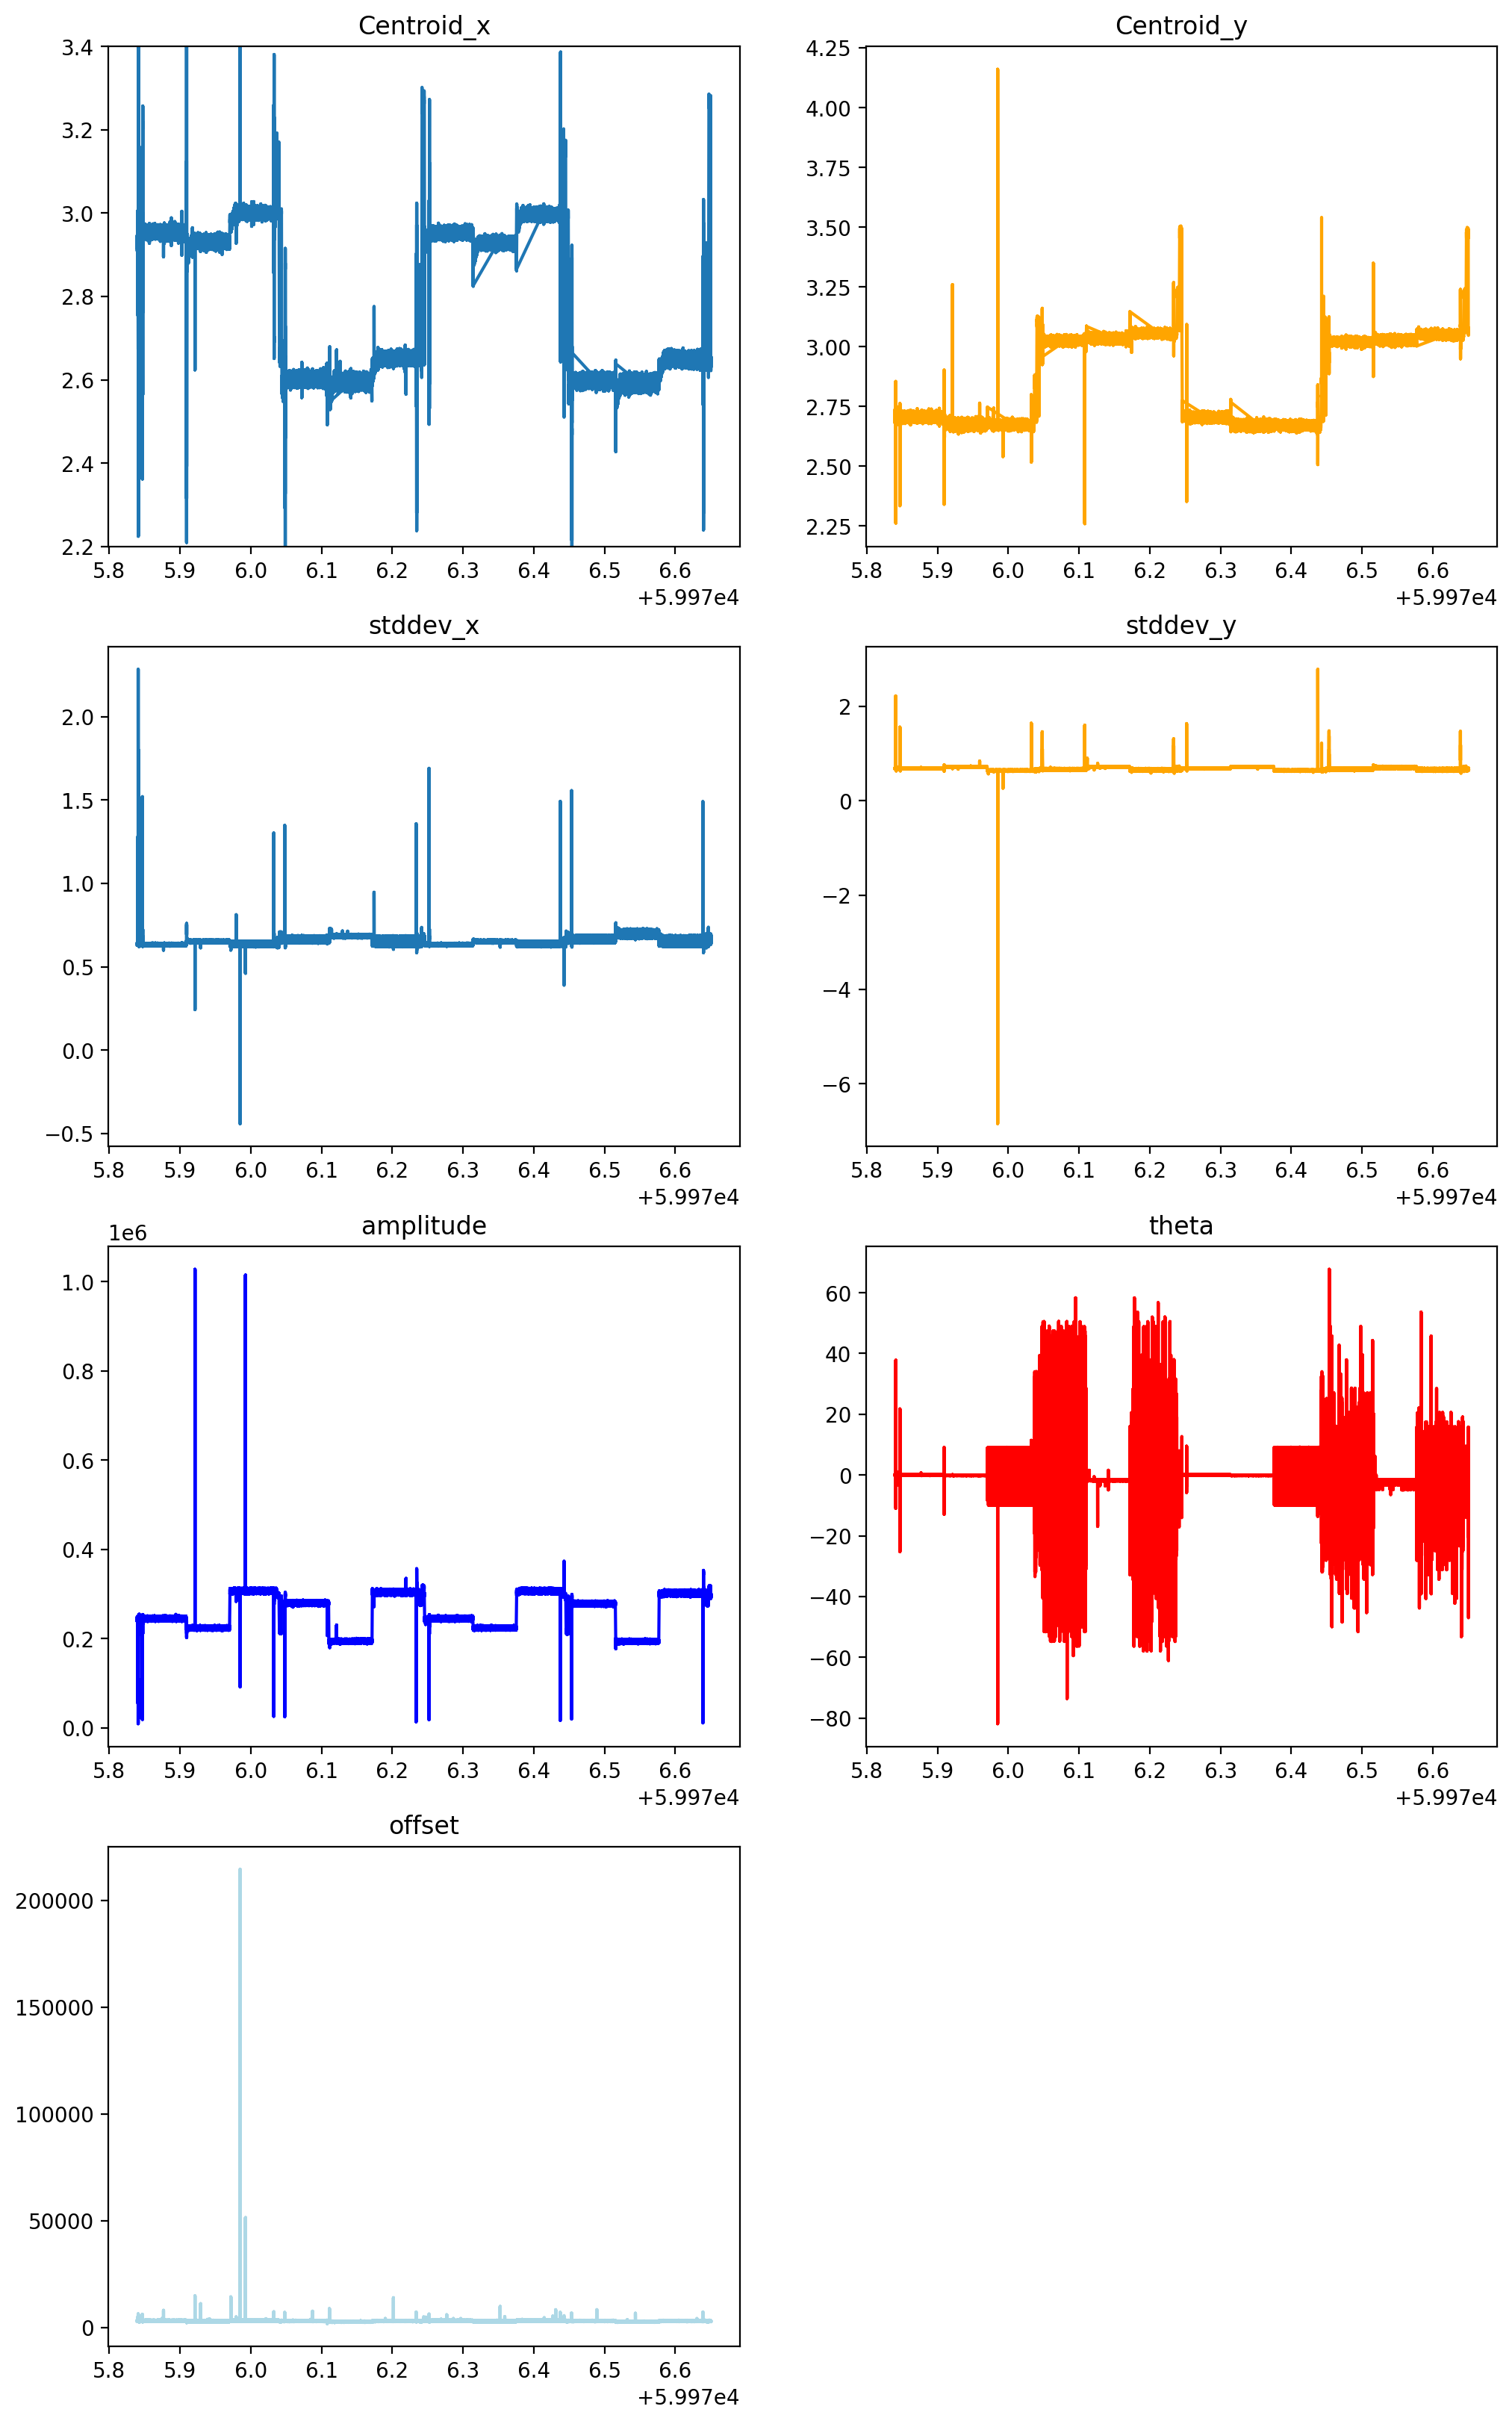

array([[<Axes: title={'center': 'Centroid_x'}>,
        <Axes: title={'center': 'Centroid_y'}>],
       [<Axes: title={'center': 'stddev_x'}>,
        <Axes: title={'center': 'stddev_y'}>],
       [<Axes: title={'center': 'amplitude'}>,
        <Axes: title={'center': 'theta'}>],
       [<Axes: title={'center': 'offset'}>, <Axes: >]], dtype=object)

In [24]:
spk.timeseries_list_plot(gaussfit_table, spk.fg_time)

We can clearly see that there are some periodic changes in the centroids every 0.2mjd with even smaller changes within. Lets zoom into one of the centroid plots.

(59976.03, 59976.05)

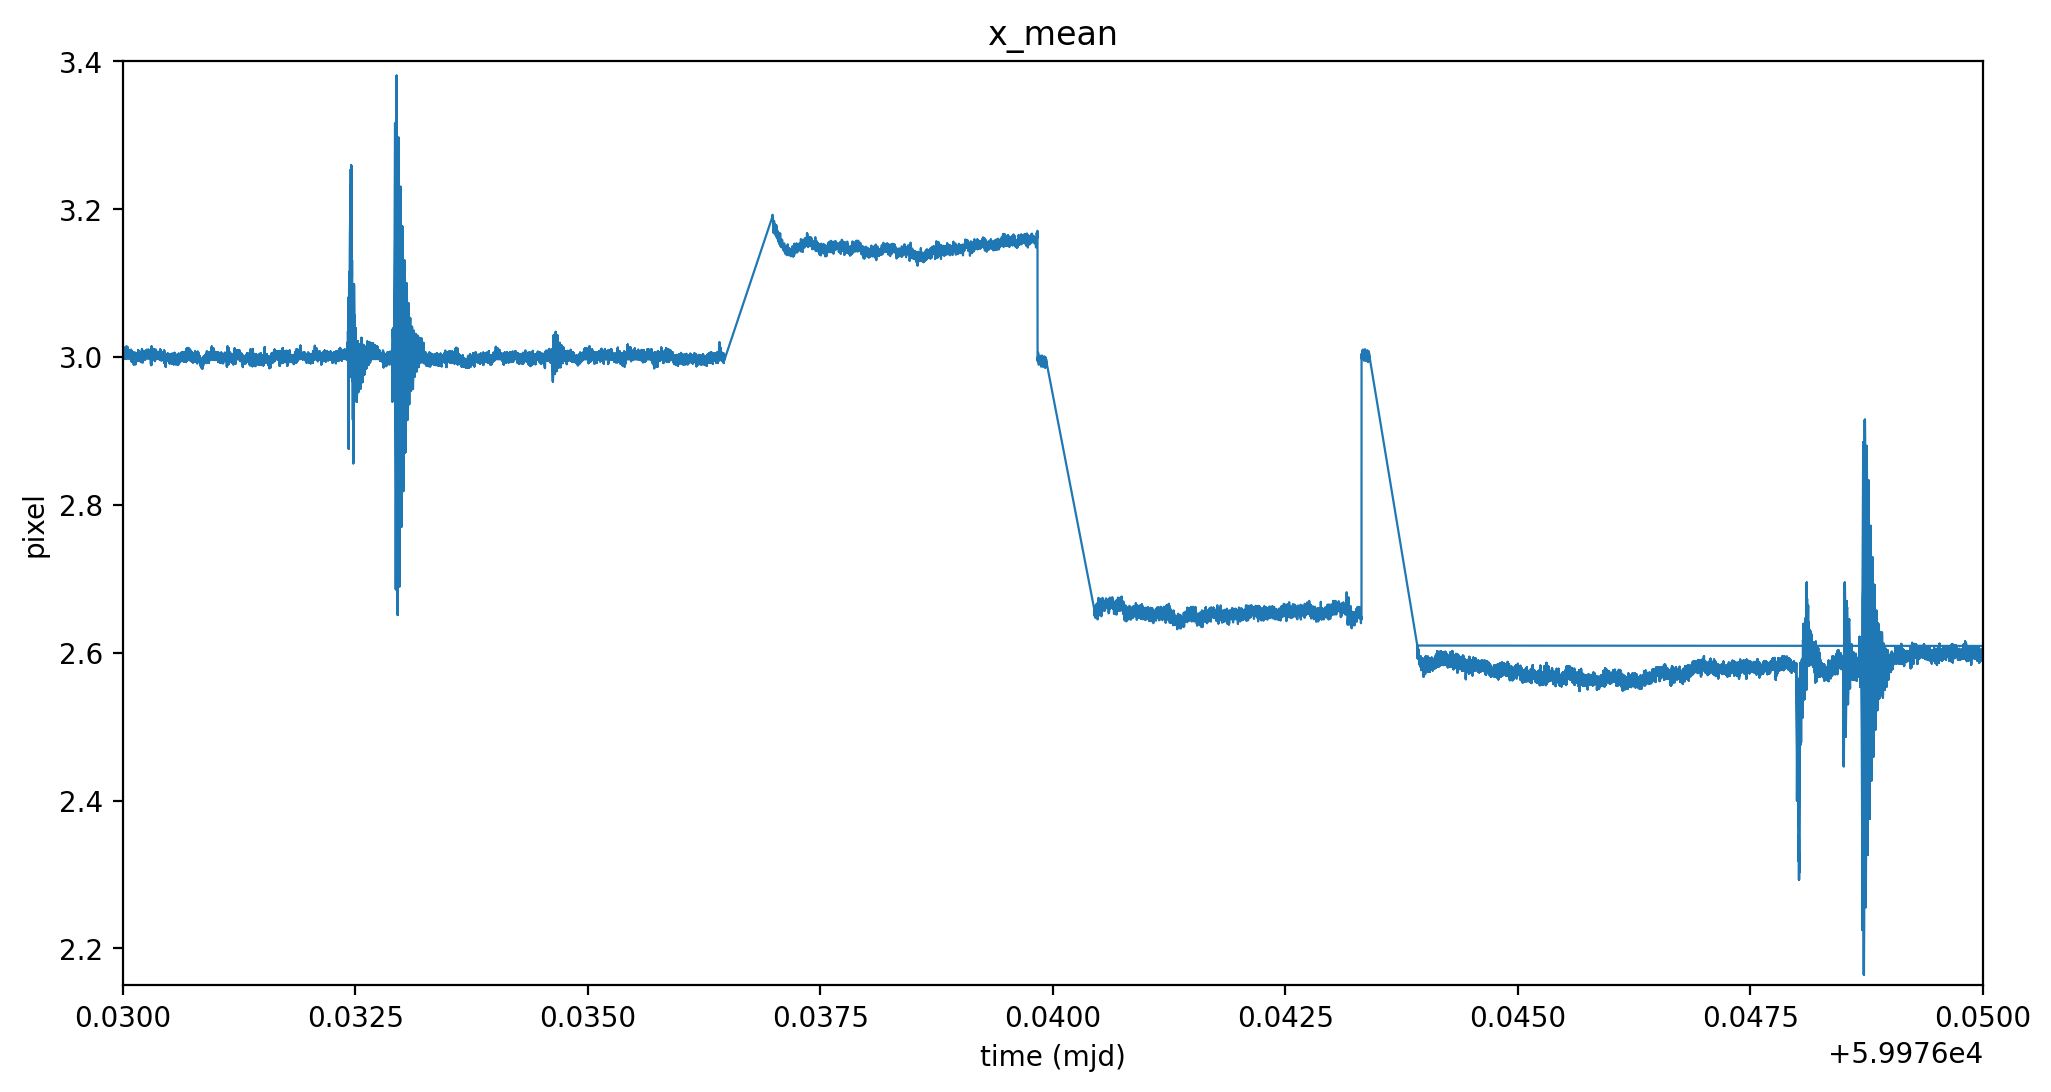

In [15]:
fig, ax = plt.subplots(figsize=(12,6), dpi=200)

ax.plot(spk.fg_time, gaussfit_table['x_mean'], linewidth=.8)
ax.set_ylabel('pixel')
ax.set_xlabel('time (mjd)')
ax.set_title('x_mean')
ax.set_ylim(2.15,3.4)
ax.set_xlim(59976.03, 59976.05)

We can see there is multiple events happening. First off, there are certain breaks between the timeseries, which indicates the time where the FGS was not observing. Everytime the FGS starts observing again, the flux changes, even though we know the guidestar is the same. This raises more investigative questions such as why does the flux change after each observation if we are looking at the same target? Additonally, there towards 59976.045 mjd, the x centroid slightly decreases within a fraction of a pixel. This maybe a product of the gaussian function where pixel sensitivity or wide PSF affects the shape of the Gaussians. There is also two events that occur on the ends of the timeseries. Lets zoom into the event on the right and apply mnemonics.

(59976.0475, 59976.0495)

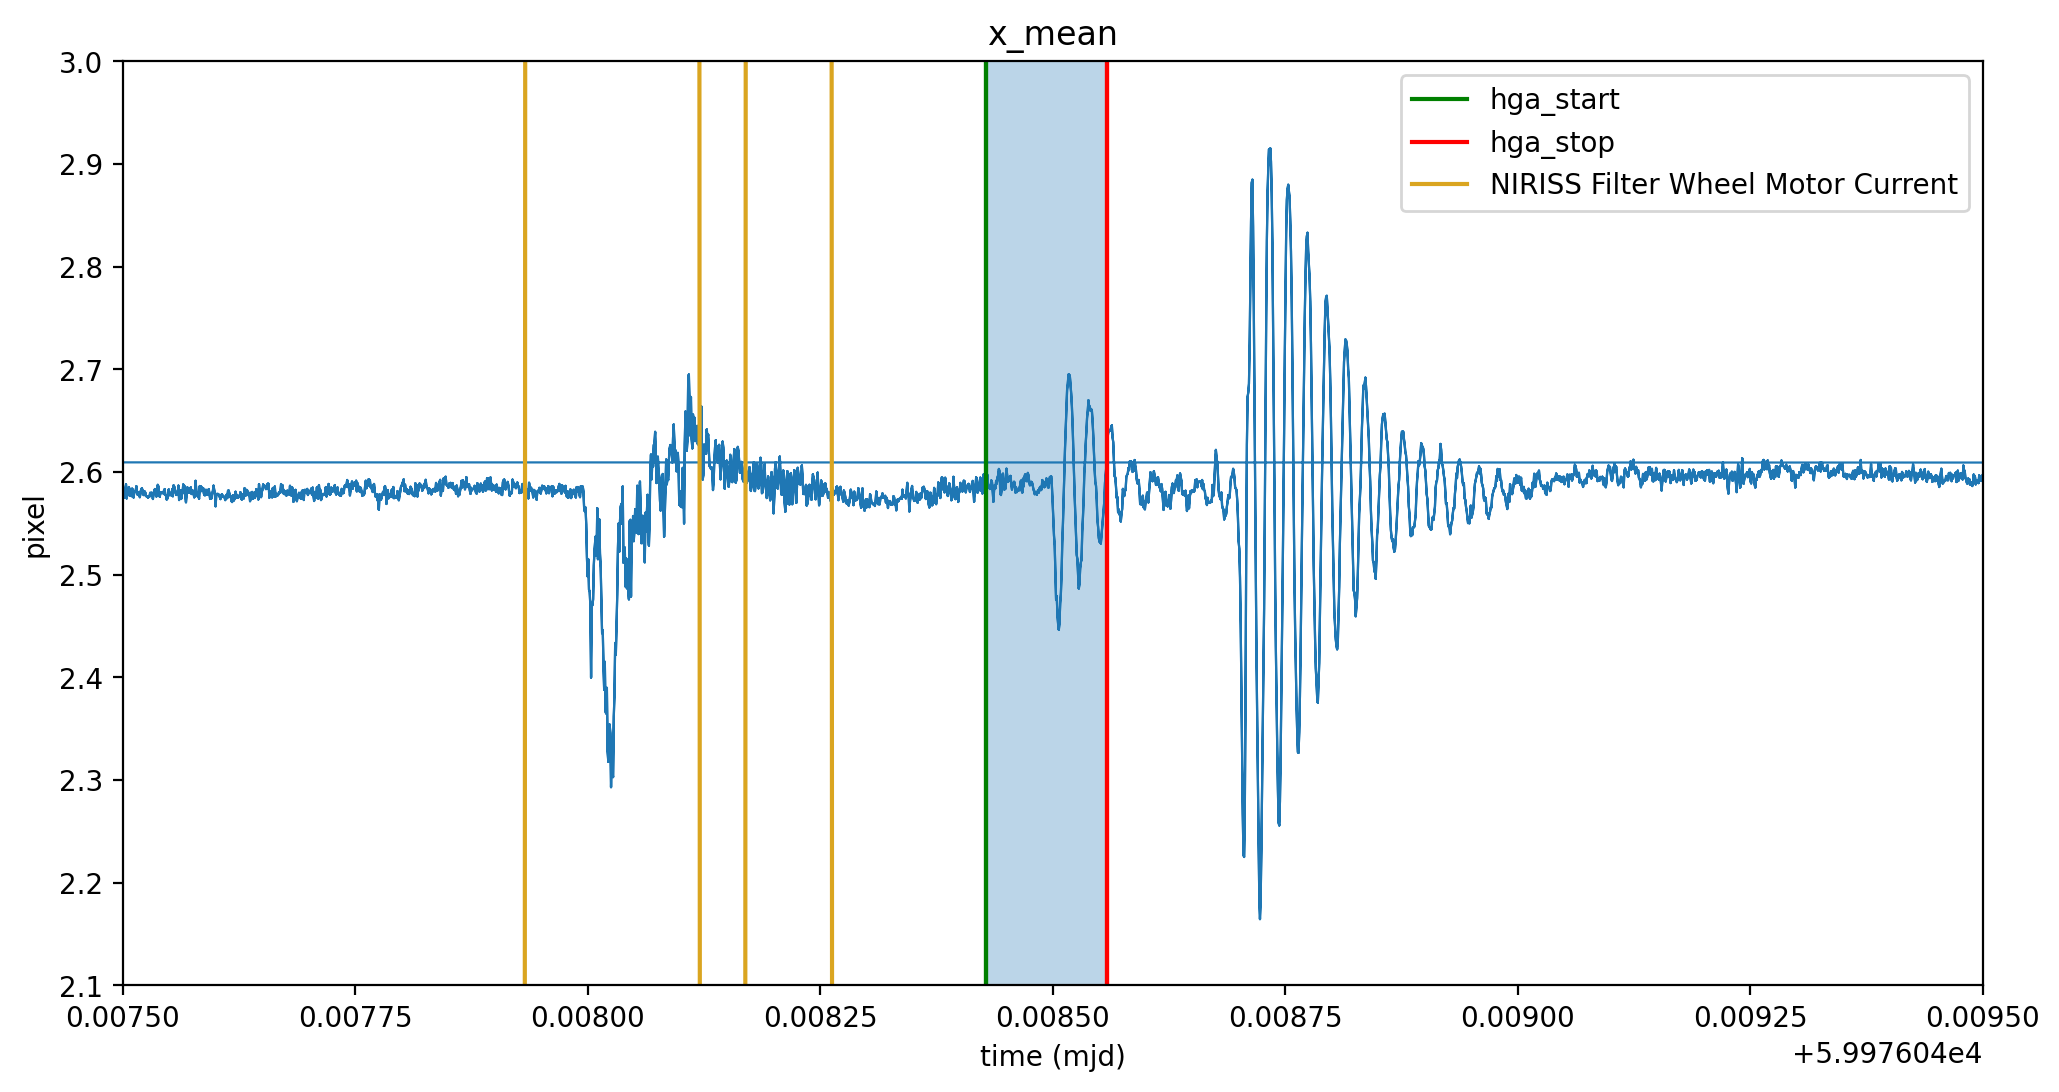

In [16]:
from matplotlib.lines import Line2D

fig, ax = plt.subplots(figsize=(12,6), dpi=200)

ax.plot(spk.fg_time, gaussfit_table['x_mean'], linewidth=.8)

ax = spk.mnemonics('SA_ZHGAUPST', 59976.0475, 59976.05) # We can overlay multiple mnemonics on top of each other

ax1 = spk.mnemonics('INIS_FWMTRCURR', 59976.0475, 59976.05)

# ### https://stackoverflow.com/a/56551701
# handles, labels = plt.gca().get_legend_handles_labels()
# orange =  Line2D([0], [0], label='NIRISS Filter Wheel Motor Current', color='orange')
# handles.extend([orange])
# ###

ax.legend()

ax.set_ylabel('pixel')
ax.set_xlabel('time (mjd)')
ax.set_title('x_mean')
ax.set_ylim(2.1,3.0)
ax.set_xlim(59976.0475, 59976.0495)

We can clearly see that some of the centroid movement can be attributed to the high-gain antenna (HGA) and even events from the NIRISS Filter Wheel.

Lastly, lets create a spatial animation of the timeseries for the guidestar for another event.

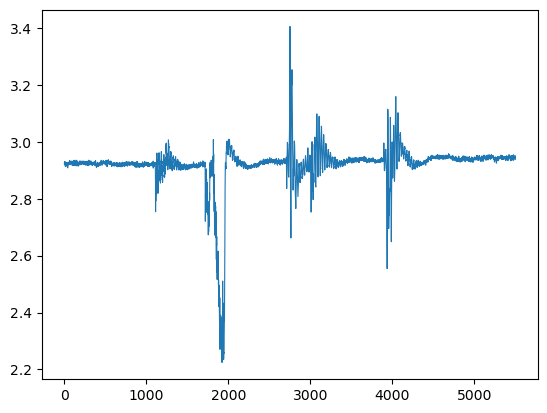

In [17]:
plt.plot(gaussfit_table['x_mean'][51500:57000], linewidth=.8)
plt.show()

2023-07-18 21:04:16,308	INFO worker.py:1636 -- Started a local Ray instance.


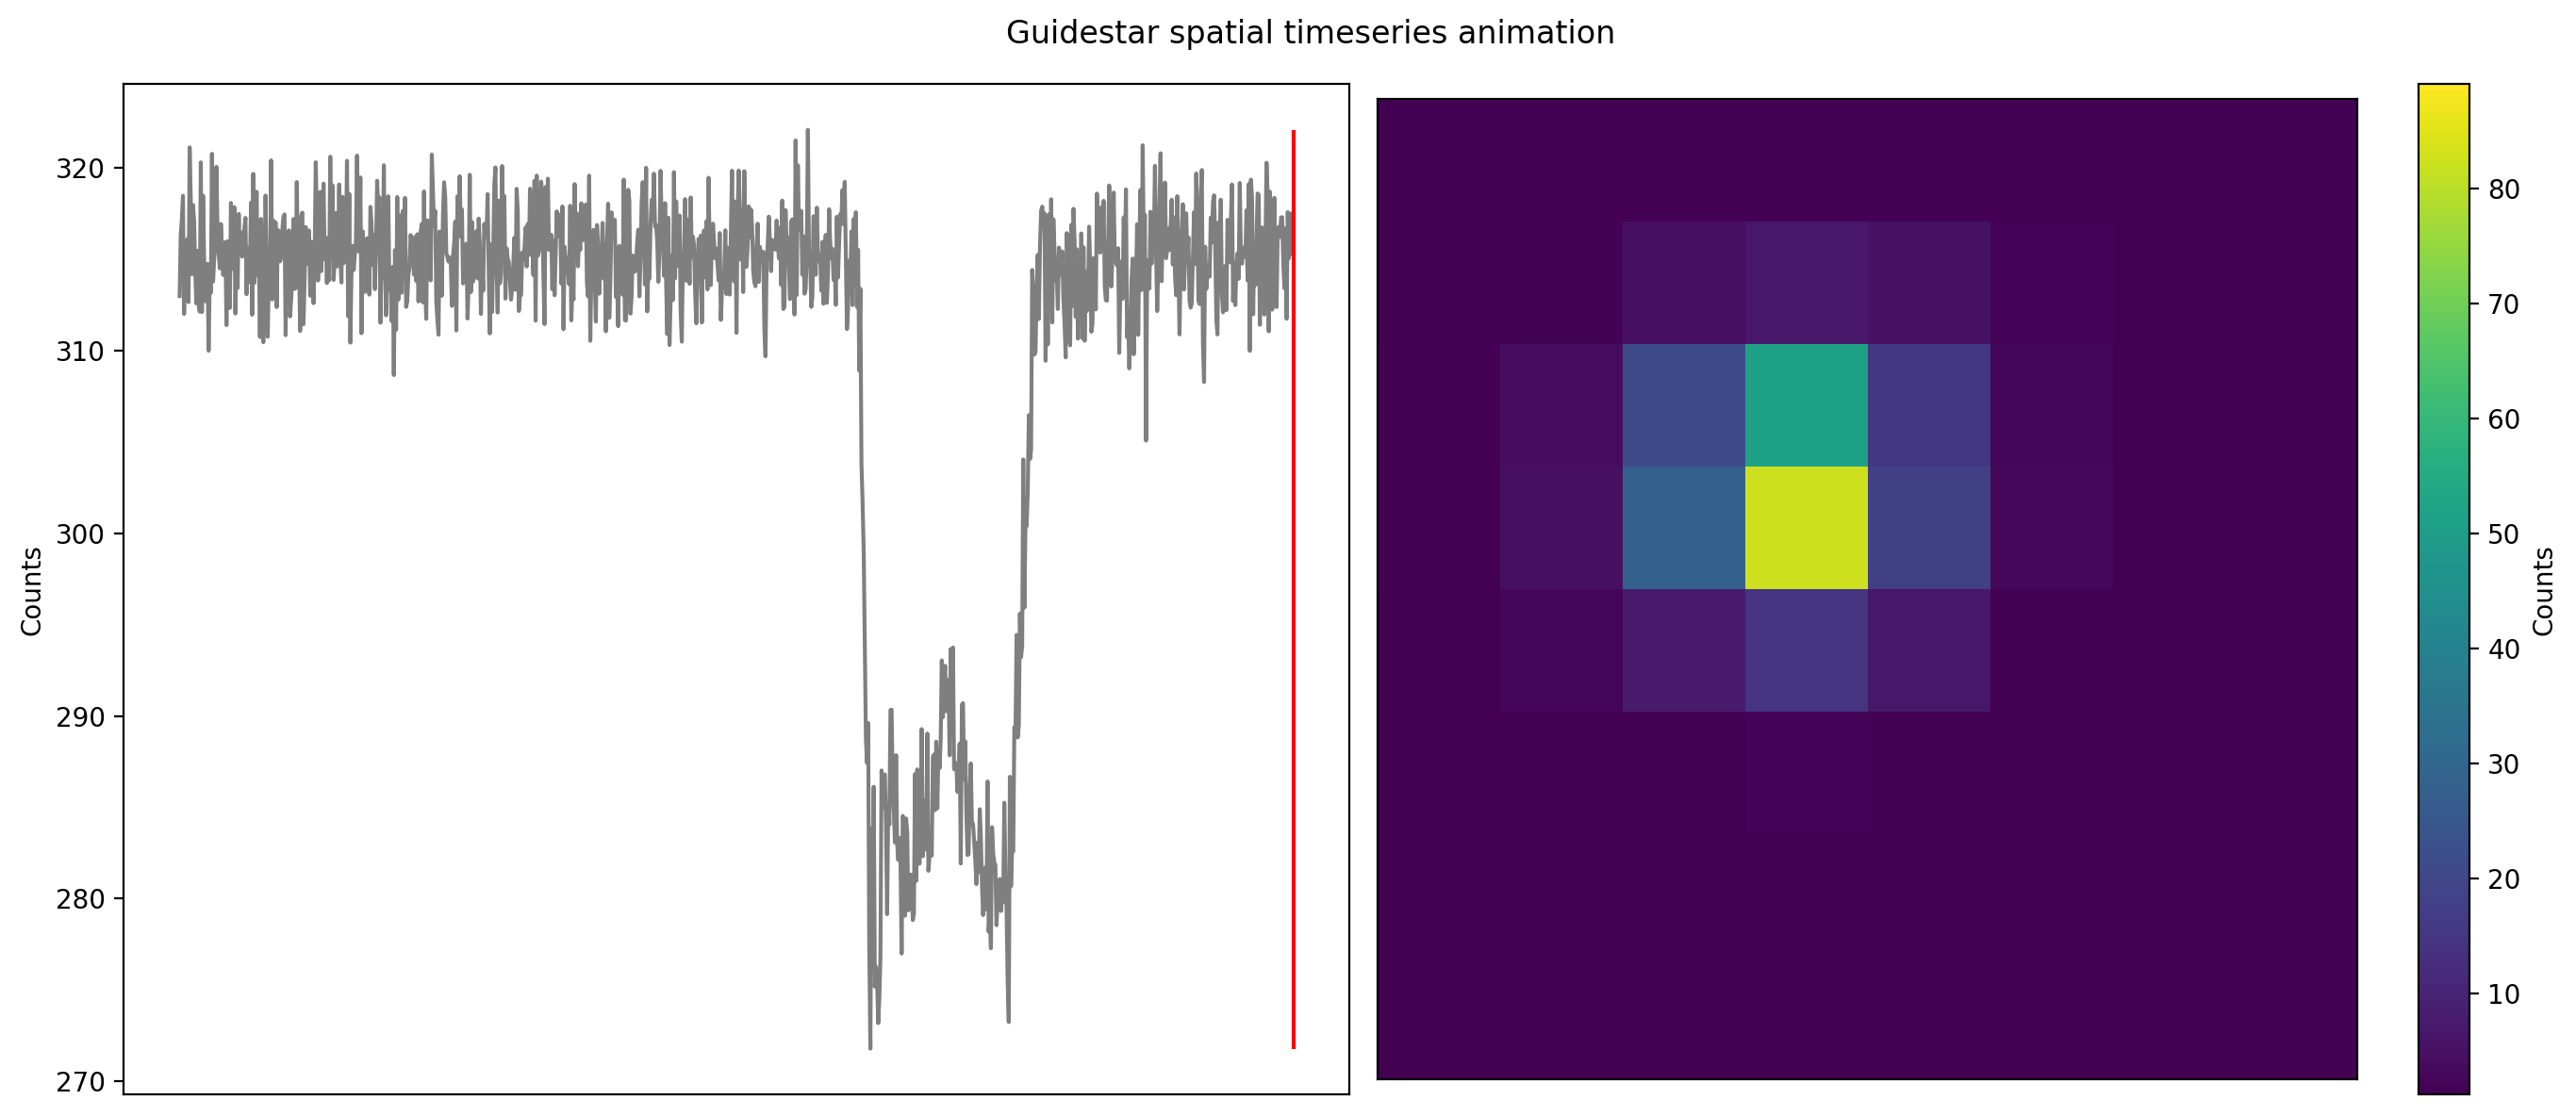

In [18]:
filename = '/Users/ddeal/JWST-Treasure-Chest/event1_2079_xmean.gif'
spk.flux_spatial_timelapse_animation(spk.fg_array[52000:53000], spk.fg_flux[52000:53000], filename=filename)

![](/Users/ddeal/JWST-Treasure-Chest-2023/JWST-FGS-Spelunker-Repos/JWST-FGS-Spelunker/plots/1541movie.gif)